# Model validation altimetry

Note: this notebook requires the model output data

<div class="alert alert-warning" role="alert">
  <strong>⚠️ Important Disclaimer</strong><br><br>
  This model setup is a <strong>simplified version</strong> of a detailed model developed by DHI. It does <strong>not</strong> resolve fine-scale processes and is <strong>not calibrated</strong> for operational use. Use is limited to <strong>educational and research purposes only</strong> — results should <strong>not</strong> inform decision-making. Performance shown here does <strong>not</strong> represent that of DHI’s high-resolution models.
</div>

### Load packages

In [38]:
import matplotlib.pyplot as plt
import modelskill as ms
import helper as h
import mikeio
import warnings

In [39]:
obs_fldr = "../observations/" 
alt_fldr = "../observations/altimetry/"
mr_fldr = "../output/"    
#mr_fldr = "../output_sample/"     # use this if you have not downloaded the full data from Zenodo yet
mr_fn = f"{mr_fldr}Area.dfsu"

save_png = False if "sample" in mr_fldr else True

### Get altimetry obs

In [40]:
altlist = h.get_altimetry_obs()
altlist

[<TrackObservation>: 3a
 Time: 2022-01-01 10:56:44 - 2023-12-30 21:10:02
 Quantity: Significant Wave Height [meter],
 <TrackObservation>: 3b
 Time: 2022-01-01 10:17:30 - 2023-12-30 10:45:22
 Quantity: Significant Wave Height [meter],
 <TrackObservation>: 6a
 Time: 2022-01-01 20:26:32 - 2023-12-30 16:14:10
 Quantity: Significant Wave Height [meter],
 <TrackObservation>: c2
 Time: 2022-01-01 21:43:30.480000 - 2023-12-29 09:22:09.814000
 Quantity: Significant Wave Height [meter],
 <TrackObservation>: j3
 Time: 2022-01-01 20:26:03.960000 - 2023-12-30 09:18:22.820000
 Quantity: Significant Wave Height [meter],
 <TrackObservation>: sa
 Time: 2022-01-01 04:50:12.885000 - 2023-12-30 18:39:58.090000
 Quantity: Significant Wave Height [meter]]

### Model validation

In [41]:
# Exclude the first two days of 2022 to avoid spin-up effects (only for full output data)
if "sample" not in mr_fldr:
    mr = ms.DfsuModelResult(mikeio.read(mr_fn,time=slice("2022-01-03","2023-12-31"))[0], name="MIKE21")

In [42]:
cmps = []
match_years = ["2022", "2023"] # You can choose a specific time period here

for o in altlist:
    print(f"Processing {o.name}...")
    try:
        for year in match_years:
            with warnings.catch_warnings():
                warnings.simplefilter("ignore")
                cmp = ms.match(obs=o.sel(time=year), mod=mr)
                cmps.append(cmp)
    except Exception as e:
        print(e)

cc = ms.ComparerCollection(cmps)

Processing 3a...
Processing 3b...
Processing 6a...
Processing c2...
Processing j3...
Processing sa...


### Skill table

In [43]:
cc.skill().round(4)

,n,bias,rmse,urmse,mae,cc,si,r2
observation,,,,,,,,
3a,27842,0.1489,0.3390,0.3046,0.2548,0.9627,0.2004,0.8807
3b,29125,0.1159,0.3399,0.3196,0.2542,0.9521,0.2160,0.8665
6a,36833,0.1655,0.3427,0.3001,0.2535,0.9614,0.1996,0.8749
c2,27382,0.1186,0.3405,0.3192,0.2464,0.9603,0.2094,0.8588
j3,33466,0.0736,0.3202,0.3117,0.2370,0.9590,0.1976,0.8866
sa,24228,0.0952,0.3263,0.3121,0.2309,0.9583,0.2025,0.8770


### Scatter plots

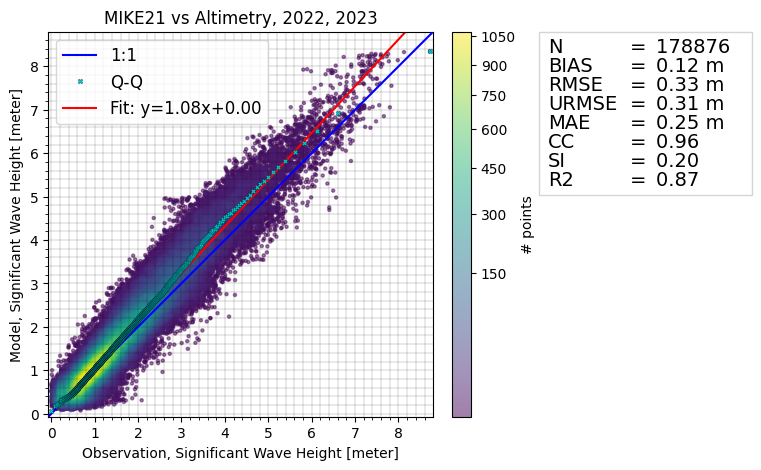

In [44]:
cc.plot.scatter(skill_table=True, show_points=True, figsize=(6,5))
plt.title("MIKE21 vs Altimetry, " + ", ".join(match_years))
if save_png: 
    plt.savefig("../figures/altimetry_comparison.png", bbox_inches="tight")

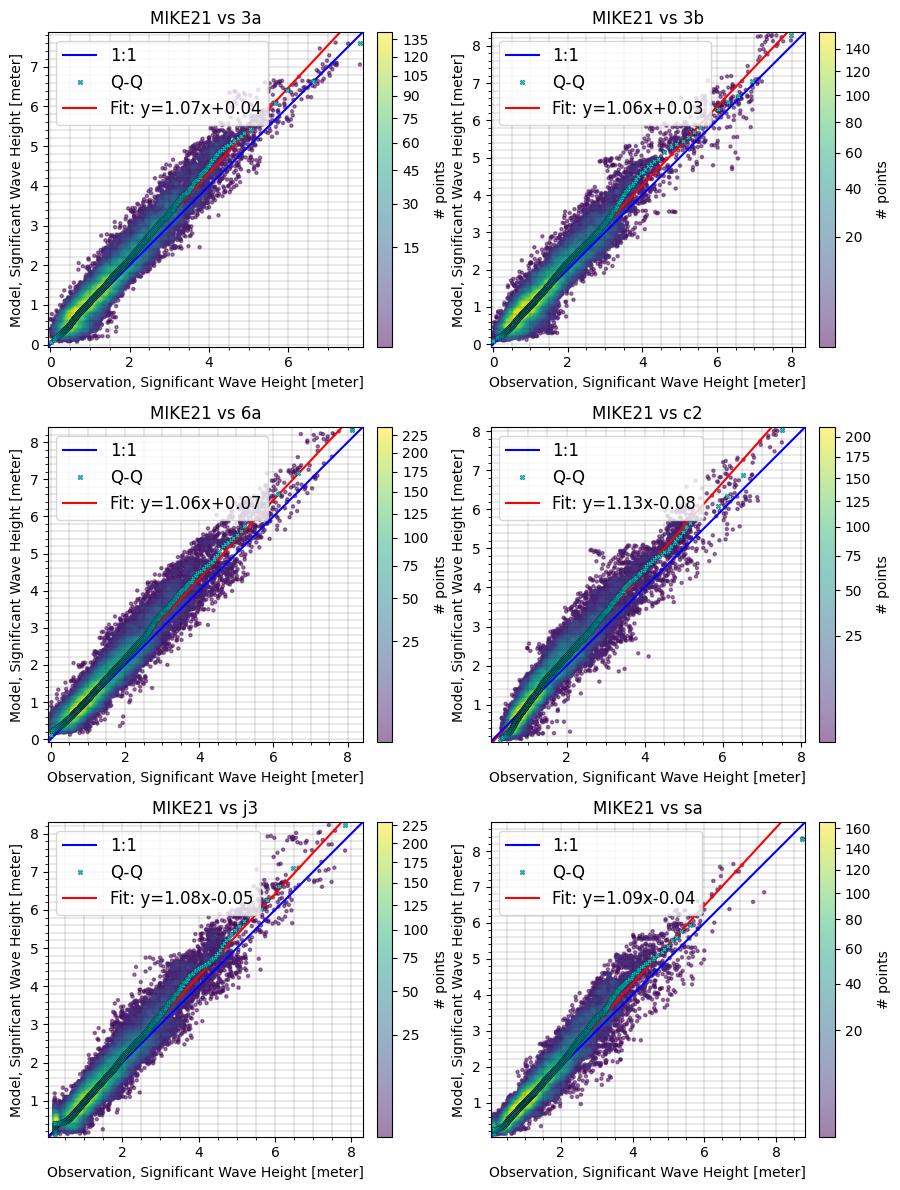

In [45]:
fig, axs = plt.subplots(-(-len(cc)//2), 2, figsize=(9,len(cc)*2))
axs = axs.flatten()
for i in range(len(cc)):
    cc[i].sel().plot.scatter(ax=axs[i], show_points=True)

if len(cc) % 2 != 0:
    axs[-1].axis("off")
plt.tight_layout()
plt.show()